<a href="https://colab.research.google.com/github/Justinezgh/SBI-Diff-Simulator/blob/u%2FJustinezgh%2Fgradients_stochasticity/notebooks/dev/GradientsStochasticity_GB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
!pip install --quiet git+https://github.com/Justinezgh/SBI-Diff-Simulator.git
!pip install --quiet numpyro jax-cosmo dm-haiku==0.0.5 optax

     |████████████████████████████████| 132 kB 3.7 MB/s 
     |████████████████████████████████| 292 kB 42.8 MB/s 
     |████████████████████████████████| 283 kB 5.2 MB/s 
     |████████████████████████████████| 287 kB 37.1 MB/s 
     |████████████████████████████████| 154 kB 48.4 MB/s 
     |████████████████████████████████| 85 kB 2.3 MB/s 


In [2]:
%pylab inline 
import jax 
import jax.numpy as jnp 
from numpyro.handlers import seed, trace, condition, substitute
import numpyro.distributions as dist

from functools import partial
from tqdm import tqdm

import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd= tfp.distributions

import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())


from sbids.tasks.galtonboard import galton_board
from sbids.tasks.utils import get_samples_and_scores
from sbids.metrics.c2st import c2st

Populating the interactive namespace from numpy and matplotlib


In [3]:
import seaborn as sns 
sns.set_theme()

Create task

In [58]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import cond


__all__=["galton_board"]

def sigmoid_(x):
    return 1. / (1. + jnp.exp(-x))

def nail_positions(theta, n_rows, n_nails, level, nail):
    """
    Compute the probability p(zh, zv, θ) of going left. 
    
    Args:
        theta: parameter used for the probability of bouncing to the left
        n_rows: number of rows in the galton board
        n_nails: number of nails in the galton board
        level: current row
        nail: current nail
    """

    level_rel = 1. * level / (n_rows - 1) #zv
    nail_rel = 2. * nail / (n_nails - 1) - 1. #zh

    nail_positions = ((1. - jnp.sin(jnp.pi * level_rel)) * 0.5
                      + jnp.sin(jnp.pi * level_rel) * sigmoid_(10 * theta * nail_rel))
    
    res = cond(level % 2 == 1 and nail == 0, 
                       lambda _: 0.0, 
                       lambda _: cond(level % 2 == 1 and nail == n_nails, 
                                                 lambda _: 1.0, 
                                                 lambda _: nail_positions, 
                                                 0), 
                       0)

    return res

def galton_board2(y = None,  n_rows = 20, n_nails = 10000):
  """
  Probabilistic model for the Generalized Galton Board example as described
  in https://github.com/johannbrehmer/simulator-mining-example.

  Args:
    y: bin in which the ball ends up 
    n_rows: number of rows in the galton board
    n_nails: number of nails in the galton board
  """

  theta = numpyro.sample('theta', dist.Uniform(-1, 0))
  pos = n_nails // 2

  for level in range(n_rows):
    pos = numpyro.sample('z%d' %level,  
                      dist.TransformedDistribution(dist.Bernoulli(1 - nail_positions(theta, n_rows, n_nails, level, pos)), 
                                              dist.transforms.AffineTransform( - (level % 2) + pos, 1)))
  y = numpyro.sample("y", 
                      dist.TransformedDistribution(dist.Bernoulli(1 - nail_positions(theta, n_rows, n_nails, level, pos)), 
                                              dist.transforms.AffineTransform(- (level % 2) + pos, 1)), 
                      obs=y)

  return y 

In [5]:
theta = -1.

model = partial(galton_board2, n_rows = 10)
cond_model = condition(model, {'theta': theta})
master_key = jax.random.PRNGKey(0)
master_key, keys = jax.random.split(master_key)
(log_probs, samples10), scores = get_samples_and_scores(cond_model, 
                                                    keys, 
                                                    batch_size=100000, 
                                                    score_type='density', 
                                                    thetas=None)


model = partial(galton_board2, n_rows = 30)
cond_model = condition(model, {'theta': theta})
master_key = jax.random.PRNGKey(0)
master_key, keys = jax.random.split(master_key)
(log_probs, samples30), scores = get_samples_and_scores(cond_model, 
                                                    keys, 
                                                    batch_size=100000, 
                                                    score_type='density', 
                                                    thetas=None)

model = partial(galton_board2, n_rows = 50)
cond_model = condition(model, {'theta': theta})
master_key = jax.random.PRNGKey(0)
master_key, keys = jax.random.split(master_key)
(log_probs, samples50), scores = get_samples_and_scores(cond_model, 
                                                    keys, 
                                                    batch_size=100000, 
                                                    score_type='density', 
                                                    thetas=None)

model = partial(galton_board2, n_rows = 100)
cond_model = condition(model, {'theta': theta})
master_key = jax.random.PRNGKey(0)
master_key, keys = jax.random.split(master_key)
(log_probs, samples100), scores = get_samples_and_scores(cond_model, 
                                                    keys, 
                                                    batch_size=100000, 
                                                    score_type='density', 
                                                    thetas=None)

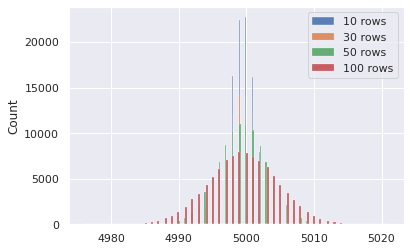

In [6]:
import seaborn as sns 
sns.set_theme()
sns.histplot(x=samples10['y'],  kde=False, alpha = 0.9, color = 'C0', label = '10 rows')
sns.histplot(x=samples30['y'],  kde=False, alpha = 0.9, color = 'C1', label = '30 rows')
sns.histplot(x=samples50['y'],  kde=False, alpha = 0.9, color = 'C2', label = '50 rows')
sns.histplot(x=samples100['y'], kde=False, alpha = 0.9, color = 'C3', label = '100 rows')
plt.legend()

In [10]:
std_ = [] 

for n_rows in [10,20,30,40,50,60,70,80,90,100]:

    model = partial(galton_board2, n_rows = n_rows)
    master_key = jax.random.PRNGKey(0)
    master_key, keys = jax.random.split(master_key)
    (log_probs, samples), scores = get_samples_and_scores(model, 
                                                        keys, 
                                                        batch_size=100000, 
                                                        score_type='density', 
                                                        thetas=None)
    std_.append(samples['y'].std())

Text(0, 0.5, 'variance')

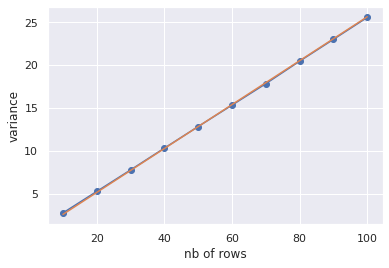

In [14]:
plt.plot([10,20,30,40,50,60,70,80,90,100], jnp.array(std_)**2, marker = 'o')
plt.plot([10,20,30,40,50,60,70,80,90,100], jnp.array([10,20,30,40,50,60,70,80,90,100])/3.9)
plt.xlabel('nb of rows')
plt.ylabel('variance')

In [12]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import cond


__all__=["galton_board"]

def sigmoid_(x):
    return 1. / (1. + jnp.exp(-x))

def nail_positions(theta, n_rows, n_nails, level, nail):
    """
    Compute the probability p(zh, zv, θ) of going left. 
    
    Args:
        theta: parameter used for the probability of bouncing to the left
        n_rows: number of rows in the galton board
        n_nails: number of nails in the galton board
        level: current row
        nail: current nail
    """

    level_rel = 1. * level / (n_rows - 1) #zv
    nail_rel = 2. * nail / (n_nails - 1) - 1. #zh

    nail_positions = ((1. - jnp.sin(jnp.pi * level_rel)) * 0.5
                      + jnp.sin(jnp.pi * level_rel) * sigmoid_(10 * theta * nail_rel))
    
    res = cond(level % 2 == 1 and nail == 0, 
                       lambda _: 0.0, 
                       lambda _: cond(level % 2 == 1 and nail == n_nails, 
                                                 lambda _: 1.0, 
                                                 lambda _: nail_positions, 
                                                 0), 
                       0)

    return res

def galton_board(y = None,  n_rows = 20, n_nails = 10000):
  """
  Probabilistic model for the Generalized Galton Board example as described
  in https://github.com/johannbrehmer/simulator-mining-example.

  Args:
    y: bin in which the ball ends up 
    n_rows: number of rows in the galton board
    n_nails: number of nails in the galton board
  """

  theta = numpyro.sample('theta', dist.Uniform(-1, 0))
  pos = n_nails // 2

  for level in range(n_rows):
    pos = numpyro.sample('z%d' %level,  
                      dist.TransformedDistribution(dist.Bernoulli(1 - nail_positions(theta, n_rows, n_nails, level, pos)), 
                                              dist.transforms.AffineTransform( - (level % 2) + pos, 1)))
  
  y = numpyro.sample("y", dist.Normal((pos - n_nails // 2) * jnp.sqrt(3.9/n_rows), 0.5))

  return y 

In [8]:
theta = -0.9

model = partial(galton_board, n_rows = 10)
cond_model = condition(model, {'theta': theta})
master_key = jax.random.PRNGKey(0)
master_key, keys = jax.random.split(master_key)
(log_probs, samples10), scores = get_samples_and_scores(cond_model, 
                                                    keys, 
                                                    batch_size=100000, 
                                                    score_type='density', 
                                                    thetas=None)


model = partial(galton_board, n_rows = 30)
cond_model = condition(model, {'theta': theta})
master_key = jax.random.PRNGKey(0)
master_key, keys = jax.random.split(master_key)
(log_probs, samples30), scores = get_samples_and_scores(cond_model, 
                                                    keys, 
                                                    batch_size=100000, 
                                                    score_type='density', 
                                                    thetas=None)

model = partial(galton_board, n_rows = 50)
cond_model = condition(model, {'theta': theta})
master_key = jax.random.PRNGKey(0)
master_key, keys = jax.random.split(master_key)
(log_probs, samples50), scores = get_samples_and_scores(cond_model, 
                                                    keys, 
                                                    batch_size=100000, 
                                                    score_type='density', 
                                                    thetas=None)

model = partial(galton_board, n_rows = 100)
cond_model = condition(model, {'theta': theta})
master_key = jax.random.PRNGKey(0)
master_key, keys = jax.random.split(master_key)
(log_probs, samples100), scores = get_samples_and_scores(cond_model, 
                                                    keys, 
                                                    batch_size=100000, 
                                                    score_type='density', 
                                                    thetas=None)

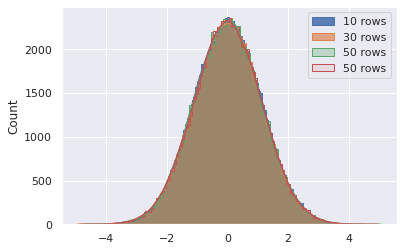

In [9]:
import seaborn as sns 
sns.set_theme()
sns.histplot(x=samples10['y'], kde=True, alpha = 0.9, element="step", color = 'C0', label = '10 rows')
sns.histplot(x=samples30['y'], kde=True, alpha = 0.7, element="step", color = 'C1', label = '30 rows')
sns.histplot(x=samples50['y'], kde=True, alpha = 0.3, element="step", color = 'C2', label = '50 rows')
sns.histplot(x=samples100['y'], kde=True, alpha = 0.1, element="step", color = 'C3', label = '50 rows')
plt.legend()

In [31]:
error_var = 100
store_score = {'10_rows': {}, '50_rows': {}, '100_rows': {}}
store_mean = {'10_rows': {}, '50_rows': {}, '100_rows': {}}

for n_rows in [10,50,100]:
  col = 0
  for theta in tqdm(arange(-1, 0 ,0.1)):
    store_score['{}_rows'.format(n_rows)]['theta_{}'.format(theta)] = []
    store_mean['{}_rows'.format(n_rows)]['theta_{}'.format(theta)] = []

    model = partial(galton_board, n_rows = n_rows, n_nails = 10000)
    cond_model = condition(model, {'theta': round(theta, 1), 
                                      })

    for bin in range(-4,4,1):
      master_key = jax.random.PRNGKey(0)
      master_key, keys = jax.random.split(master_key)
      (log_probs, samples), scores = get_samples_and_scores(cond_model, 
                                                          keys, 
                                                          batch_size=100000, 
                                                          score_type='density', 
                                                          thetas=None)
        


      indx = jnp.where(round(samples['y']) == bin)[0]

      count = 0
      if indx.shape[0] != 0 :

        while indx.shape[0] < error_var : 
          master_key, keys = jax.random.split(master_key)
          (log_probs, samples), scores = get_samples_and_scores(cond_model, 
                                                            keys, 
                                                            batch_size=100000, 
                                                            score_type='density', 
                                                            thetas=None)
          indx = jnp.concatenate([indx, jnp.where(round(samples['y']) == bin)[0]])
          count += 1

          if count > int(error_var/10) : 
            indx = jnp.array([], dtype=jnp.int32)
            break

      if len(jnp.array(indx).squeeze()) > error_var : 
        indx = indx[:error_var] 

      store_score['{}_rows'.format(n_rows)]['theta_{}'.format(theta)].append(jnp.std(scores[indx]))
      store_mean['{}_rows'.format(n_rows)]['theta_{}'.format(theta)].append(jnp.mean(scores[indx]))


100%|██████████| 10/10 [48:04<00:00, 288.45s/it]


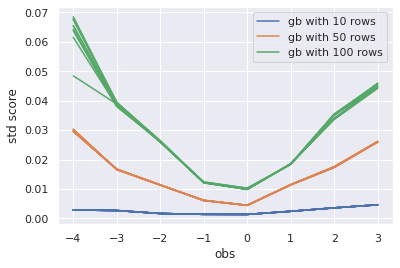

In [55]:
for theta in arange(-1, 0 ,0.1):
  col = 0
  for nb_rows in [10,50,100]:
    s = jnp.array(store_mean['{}_rows'.format(nb_rows)]['theta_{}'.format(theta)])
    n = jnp.array(store_score['{}_rows'.format(nb_rows)]['theta_{}'.format(theta)])
    plt.plot(range(-4,4,1), store_score['{}_rows'.format(nb_rows)]['theta_{}'.format(theta)], c = 'C%d'%col)
    col +=1
    
plt.xlabel('obs')
plt.ylabel('std score')
plt.legend(['gb with 10 rows', 
            'gb with 50 rows',
            'gb with 100 rows'])

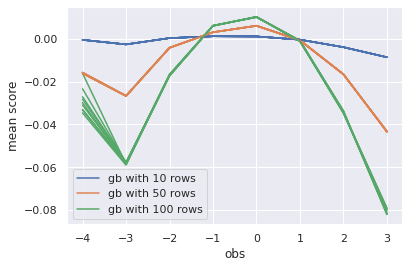

In [56]:
for theta in arange(-1, 0 ,0.1):
  col = 0
  for nb_rows in [10,50,100]:
    s = jnp.array(store_mean['{}_rows'.format(nb_rows)]['theta_{}'.format(theta)])
    n = jnp.array(store_score['{}_rows'.format(nb_rows)]['theta_{}'.format(theta)])
    plt.plot(range(-4,4,1), store_mean['{}_rows'.format(nb_rows)]['theta_{}'.format(theta)], c = 'C%d'%col)
    col +=1
    
plt.xlabel('obs')
plt.ylabel('mean score')
plt.legend(['gb with 10 rows', 
            'gb with 50 rows',
            'gb with 100 rows'])

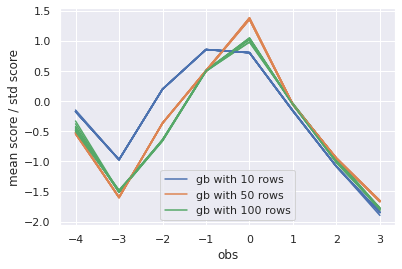

In [52]:
for theta in arange(-1, 0 ,0.1):
  col = 0
  for nb_rows in [10,50,100]:
    s = jnp.array(store_mean['{}_rows'.format(nb_rows)]['theta_{}'.format(theta)])
    n = jnp.array(store_score['{}_rows'.format(nb_rows)]['theta_{}'.format(theta)])
    plt.plot(range(-4,4,1),
             s / n, 
             c = 'C%d'%col)
    col +=1
    
plt.xlabel('obs')
plt.ylabel('mean score / std score')
plt.legend(['gb with 10 rows', 
            'gb with 50 rows',
            'gb with 100 rows'])

Inference with NPE

In [13]:
import jax.numpy as jnp
import jax
import haiku as hk
import optax

import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions

from sbids.bijectors import MixtureAffineSigmoidBijector


# create differentiable coupling layer

class AffineSigmoidCoupling(hk.Module):
  """This is the coupling layer used in the Flow."""
  def __init__(self, y, *args, layers=[128, 128], n_components=32, activation=jax.nn.silu, **kwargs):
    """ 
    Args: 
    y, conditioning variable
    layers, list of hidden layers
    n_components, number of mixture components
    activation, activation function for hidden layers
    """
    self.y = y
    self.layers = layers
    self.n_components = n_components
    self.activation = activation
    super(AffineSigmoidCoupling, self).__init__(*args, **kwargs)

  def __call__(self, output_units, **condition_kwargs):
   
    net = jnp.concatenate([self.y], axis=-1)
    for i, layer_size in enumerate(self.layers):
      net = self.activation(hk.Linear(layer_size, name='layer%d' % i)(net))
    
    log_a_bound=4
    min_density_lower_bound=1e-4
    n_components=self.n_components
    
    log_a = jax.nn.tanh(hk.Linear(output_units*n_components, name='l3')(net)) * log_a_bound
    b   = hk.Linear(output_units*n_components, name='l4')(net)
    c   = min_density_lower_bound + jax.nn.sigmoid(hk.Linear(output_units*n_components, name='l5')(net)) * (1 - min_density_lower_bound)
    p   = hk.Linear(output_units*n_components, name='l6')(net)

    log_a = log_a.reshape(-1,output_units,n_components)
    b = b.reshape(-1,output_units,n_components)
    c = c.reshape(-1,output_units,n_components)
    p = p.reshape(-1,output_units,n_components)
    p = jax.nn.softmax(p)

    return MixtureAffineSigmoidBijector(jnp.exp(log_a),b,c,p)

class ConditionalRealNVP(hk.Module):
  """A normalizing flow based on RealNVP using specified bijector functions."""

  def __init__(self, d, *args, n_layers=3, bijector_fn=AffineSigmoidCoupling, **kwargs):
    """
    Args:
    d, dimensionality of the input
    n_layers, number of layers
    coupling_layer, list of coupling layers
    """
    self.d = d
    self.n_layer = n_layers
    self.bijector_fn = bijector_fn
    super(ConditionalRealNVP, self).__init__(*args, **kwargs)
    
  def __call__(self, y):
    chain = tfb.Chain([(self.bijector_fn(y, name = 'b%d'%i)(output_units = self.d)) for i in range(self.n_layer)])


    nvp = tfd.TransformedDistribution(
          tfd.MultivariateNormalDiag(0.5*jnp.ones(self.d), scale_identity_multiplier=0.05),
          bijector=chain)
    
    return nvp


from functools import partial
bijector_layers = [128] * 2

bijector_npe = partial(
  AffineSigmoidCoupling, 
  layers=bijector_layers, 
  n_components=16, 
  activation=jax.nn.silu
)

NF_npe = partial(
  ConditionalRealNVP, 
  n_layers=4, 
  bijector_fn=bijector_npe)

/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
  0%|          | 0/20000 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)
/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
100%|██████████| 20000/20000 [05:27<00:00, 60.99it/s]
/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will


 ___score weight :  1


/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
100%|██████████| 20000/20000 [04:50<00:00, 68.74it/s]
/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)



 ___score weight :  0


/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
100%|██████████| 20000/20000 [04:47<00:00, 69.61it/s]
/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)
/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
  0%|          | 0/20000 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will


 ___score weight :  1


/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
100%|██████████| 20000/20000 [04:47<00:00, 69.65it/s]
/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)



 ___score weight :  0


/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
100%|██████████| 20000/20000 [04:43<00:00, 70.58it/s]
/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)


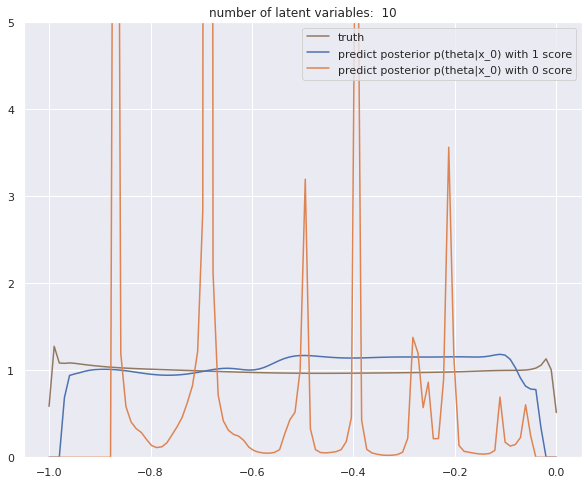

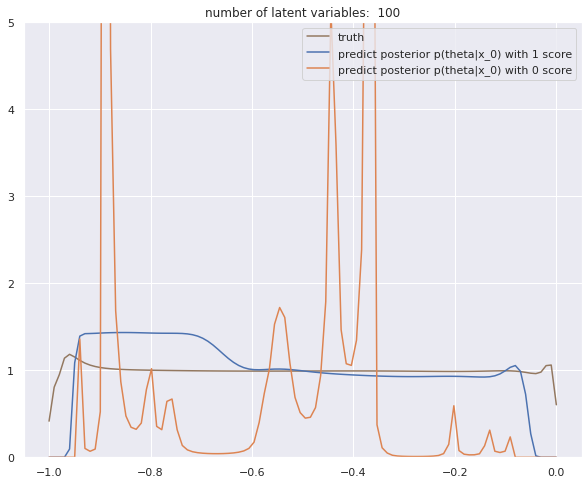

In [26]:
batch_size = 40
master_key = jax.random.PRNGKey(0)

c2st_ = []


  
for nb_rows in [10,100]:

  plt.figure(figsize = (10,8))
  plt.title('number of latent variables: % d' % nb_rows)

  # create dataset 
  model = partial(galton_board, n_rows = nb_rows)
  (log_probs, samples), scores = get_samples_and_scores(model, 
                                                        jax.random.PRNGKey(101), 
                                                        batch_size=int(1e5), 
                                                        score_type='density', 
                                                        thetas=None)
  
  theta, x, score = samples['theta'], samples['y'], scores

  scale_reg = (jnp.std(x, axis = 0)/0.06)
  shift_reg = jnp.mean(x/scale_reg, axis = 0)-0.5
  scale_theta = (jnp.std(theta, axis = 0)/0.06)
  shift_theta = jnp.mean(theta/scale_theta, axis = 0)-0.5

  # create fiducial
  theta_fiducial = -0.8
  model_fiducial = partial(galton_board, n_rows = nb_rows)
  (_, x_0), _ = get_samples_and_scores(condition(model_fiducial, {'theta': theta_fiducial}), 
                                       jax.random.PRNGKey(0), 
                                       batch_size=1, 
                                       score_type='density', 
                                       thetas=None)
  x_0 = x_0['y']

  # create nf model 
  class SmoothNPE(hk.Module):
      def __call__(self, y):
          net = y/scale_reg - shift_reg
          nvp = NF_npe(1)(net)
          return tfd.TransformedDistribution(tfd.TransformedDistribution(nvp,
                                            tfb.Chain([tfb.Scale(scale_theta),
                                                        tfb.Shift(shift_theta)])),
                                            tfb.Sigmoid(-1.1,0.2))

  nvp_nd_npe = hk.without_apply_rng(hk.transform(lambda theta,y : SmoothNPE()(y).log_prob(theta).squeeze()))
  nvp_nd_npe_prob = hk.without_apply_rng(hk.transform(lambda theta,y : SmoothNPE()(y).prob(theta).squeeze()))
  nvp_sample_nd_npe = hk.transform(lambda x: SmoothNPE()(x).sample(1000, seed=hk.next_rng_key()))

  # define loss function and model update
  def loss_fn(params, weight, mu, batch, score):
    log_prob, out = jax.vmap(
      jax.value_and_grad(lambda theta, x: nvp_nd_npe.apply(params, theta.reshape([1,1]), x.reshape([1,1])).squeeze())
      )(mu, batch)
    return  -jnp.mean(log_prob) + weight * jnp.mean(jnp.sum((out - score)**2, axis=1))

  @jax.jit
  def update(params, opt_state, weight, mu, batch, score):
      """Single SGD update step."""
      loss, grads  = jax.value_and_grad(loss_fn)(params, weight, mu, batch, score)
      updates, new_opt_state = optimizer_npe.update(grads, opt_state, params)
      new_params = optax.apply_updates(params, updates)
    
      return loss, new_params, new_opt_state

  # init parameters
  params_nd_npe = nvp_nd_npe.init(jax.random.PRNGKey(879),  0.5*jnp.ones([1,1]), 0.5*jnp.ones([1,1]))
  # init optimizer
  scheduler_npe = optax.exponential_decay(init_value=0.001, transition_steps=1000, decay_rate=0.9, end_value=0.00001)
  optimizer_npe = optax.chain(optax.scale_by_adam(), optax.scale_by_schedule(scheduler_npe), optax.scale(-1))
  opt_state_npe = optimizer_npe.init(params_nd_npe)

  # train with large number of simulations to create 'true' posterior
  batch_loss = []
  for step in tqdm(range(20000)):
      inds = np.random.randint(0, int(1e5), 128) 
      l, params_nd_npe, opt_state_npe = update(params_nd_npe, 
                                              opt_state_npe, 
                                              0, 
                                              theta[inds].reshape([-1,1]), 
                                              x[inds].reshape([-1,1]), 
                                              score[inds].reshape([-1,1]))
      if jnp.isnan(l):
        break
      batch_loss.append(l)

  thetat = jnp.linspace(-1.,0.,100)
  pred_true = jax.vmap(lambda theta : nvp_nd_npe_prob.apply(params_nd_npe, theta.reshape([1,1]), x_0.reshape([1,1])))(thetat)
  true_samp = nvp_sample_nd_npe.apply(params_nd_npe, jax.random.PRNGKey(98697), x_0 * jnp.ones([1000, 1]))
  plt.plot(thetat, pred_true, label = 'truth', color  = 'C5')

  col = 0 
  for score_weight in [1, 0]:
    for j in range(1):

      print('\n ___score weight : ', score_weight)

      # init parameters
      params_nd_npe = nvp_nd_npe.init(jax.random.PRNGKey(j),  0.5*jnp.ones([1,1]), 0.5*jnp.ones([1,1]))
      # init optimizer
      scheduler_npe = optax.exponential_decay(init_value=0.001, transition_steps=1000, decay_rate=0.9, end_value=0.00001)
      optimizer_npe = optax.chain(optax.scale_by_adam(), optax.scale_by_schedule(scheduler_npe), optax.scale(-1))
      opt_state_npe = optimizer_npe.init(params_nd_npe)

      # train
      batch_loss = []
      for step in tqdm(range(20000)):
          inds = np.random.randint(0, batch_size, 128) 
          l, params_nd_npe, opt_state_npe = update(params_nd_npe, 
                                                  opt_state_npe, 
                                                  score_weight, 
                                                  theta[inds].reshape([-1,1]), 
                                                  x[inds].reshape([-1,1]), 
                                                  score[inds].reshape([-1,1]))
          if jnp.isnan(l):
            break
          batch_loss.append(l)
      
      pred = jax.vmap(lambda theta : nvp_nd_npe_prob.apply(params_nd_npe, theta.reshape([1,1]), x_0.reshape([1,1])))(thetat)
      pred_samp = nvp_sample_nd_npe.apply(params_nd_npe, jax.random.PRNGKey(98697), x_0 * jnp.ones([1000, 1]))
      
      # evaluate posterior quality
      c2st_.append(c2st(true_samp, pred_samp, seed=0, n_folds=5))

      if j == 0:
        plt.plot(thetat, pred, color = 'C%d' %col, label = 'predict posterior p(theta|x_0) with %s score' %score_weight)
      else:
        plt.plot(thetat, pred, color = 'C%d' %col)
      plt.ylim([0,5])
      plt.legend()
    col += 1

In [27]:
c2st_

[array(0.5135, dtype=float32),
 array(0.67, dtype=float32),
 array(0.5355, dtype=float32),
 array(0.621, dtype=float32)]